In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import numpy.random as nr
import sklearn.model_selection as ms
from sklearn import preprocessing

In [2]:
df = pd.read_csv('ncaa_matches_binned.csv')
Labels = df['Win']
df.drop(df.columns[0], axis=1, inplace=True)
df.drop(['Win'], axis=1, inplace=True)
Features = np.array(df)
print(Features.shape)
df.head()

(87504, 29)


,Team2,Team1Score,Team1FGM,Team1FGA,Team1FGM3,Team1FGA3,Team1FTM,Team1FTA,Team1OR,Team1DR,...,Team2FGA3,Team2FTM,Team2FTA,Team2OR,Team2DR,Team2Ast,Team2TO,Team2Stl,Team2Blk,Team2PF
0,1411.0,2,2,2,0,1,2,1,1,2,...,0,3,3,3,3,1,0,2,2,1
1,1112.0,1,1,1,0,0,2,2,1,3,...,0,3,3,3,3,3,3,1,3,0
2,1113.0,3,3,3,1,1,3,3,3,3,...,2,2,2,0,2,3,2,1,2,1
3,1141.0,3,3,2,3,2,2,0,0,3,...,2,2,1,2,0,0,0,2,0,3
4,1301.0,2,2,2,0,0,2,1,1,3,...,1,2,2,2,3,3,3,1,3,0


In [3]:
# Randomly sample cases to create independent training and test data
nr.seed(1115)
indx = range(Features.shape[0])
indx = ms.train_test_split(indx, test_size = 5000)
X_train = Features[indx[0],:]
y_train = np.ravel(Labels[indx[0]])
X_test = Features[indx[1],:]
y_test = np.ravel(Labels[indx[1]])

In [4]:
# Rescale numeric features
scaler = preprocessing.MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
print(X_train.shape)
X_train[:5,:]

(82504, 29)


array([[0.56438356, 0.66666667, 1.        , 0.66666667, 0.        ,
        0.        , 1.        , 1.        , 1.        , 1.        ,
        0.66666667, 0.        , 0.        , 1.        , 0.        ,
        0.66666667, 0.33333333, 0.33333333, 0.66666667, 1.        ,
        1.        , 1.        , 0.        , 1.        , 1.        ,
        1.        , 0.25      , 0.66666667, 0.33333333],
       [0.62465753, 0.66666667, 0.66666667, 0.66666667, 0.        ,
        0.        , 1.        , 0.66666667, 0.        , 0.33333333,
        0.66666667, 0.66666667, 0.5       , 0.66666667, 0.33333333,
        0.66666667, 0.66666667, 0.66666667, 0.33333333, 0.5       ,
        1.        , 1.        , 0.33333333, 0.66666667, 0.66666667,
        0.66666667, 1.        , 1.        , 0.66666667],
       [0.16712329, 0.        , 0.        , 0.        , 1.        ,
        1.        , 0.        , 0.        , 0.        , 0.        ,
        0.33333333, 1.        , 0.25      , 0.        , 0.        ,
  

In [76]:
# I tried a alot of different neural network structures this one is one of the best. 
# More complext networks are all slightly worse than this one.
activation_fn = tf.nn.relu

In [176]:
inputs = tf.keras.Input(shape=(X_train.shape[1], ))  # Returns an input placeholder

# A layer instance is callable on a tensor, and returns a tensor.
x = tf.keras.layers.Dense(128, activation=activation_fn)(inputs)
x = tf.keras.layers.Dense(128, activation=activation_fn)(x)
x = tf.keras.layers.Dense(128, activation=activation_fn)(x)
outputs = tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy', 'AUC', 'Precision', 'Recall'])


In [177]:
model.fit(X_train, y_train, epochs=10, validation_split=0.2)

model.evaluate(X_test,  y_test, verbose=2)

Train on 66003 samples, validate on 16501 samples
Epoch 1/10
66003/66003 [==============================] - 5s 74us/sample - loss: 0.6319 - accuracy: 0.6338 - AUC: 0.6901 - Precision: 0.6340 - Recall: 0.6286 - val_loss: 0.6244 - val_accuracy: 0.6382 - val_AUC: 0.7031 - val_Precision: 0.6664 - val_Recall: 0.5587
Epoch 2/10
66003/66003 [==============================] - 4s 58us/sample - loss: 0.6246 - accuracy: 0.6412 - AUC: 0.7001 - Precision: 0.6399 - Recall: 0.6416 - val_loss: 0.6234 - val_accuracy: 0.6443 - val_AUC: 0.7048 - val_Precision: 0.6284 - val_Recall: 0.7126
Epoch 3/10
66003/66003 [==============================] - 4s 60us/sample - loss: 0.6222 - accuracy: 0.6439 - AUC: 0.7030 - Precision: 0.6411 - Recall: 0.6498 - val_loss: 0.6249 - val_accuracy: 0.6409 - val_AUC: 0.7047 - val_Precision: 0.6652 - val_Recall: 0.5726
Epoch 4/10
66003/66003 [==============================] - 4s 56us/sample - loss: 0.6196 - accuracy: 0.6454 - AUC: 0.7067 - Precision: 0.6434 - Recall: 0.6485 - v

[0.6143906691551209, 0.651, 0.71386534, 0.65148515, 0.65537846]

In [178]:
model.summary()

Model: "model_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        [(None, 29)]              0         
_________________________________________________________________
dense_181 (Dense)            (None, 128)               3840      
_________________________________________________________________
dense_182 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_183 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_184 (Dense)            (None, 1)                 129       
Total params: 36,993
Trainable params: 36,993
Non-trainable params: 0
_________________________________________________________________


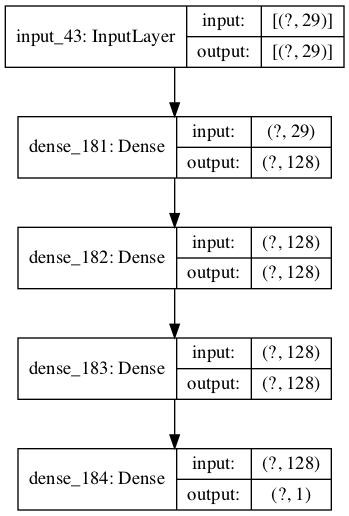

In [179]:
tf.keras.utils.plot_model(model, 'neural_network_shape_info.png', show_shapes=True)